# Editing a scene

## Overview

In this tutorial, you will learn how to modify a Mitsuba scene after it has been loaded from a file. You might want to edit a scene before (re-)rendering it for many reasons. Maybe a corner is dim, or an object should be moved a bit to the left. Thankfully we can use the *traverse* mechanism to perform such modifications in Python with Mitsuba 3. As we will see in later tutorials, this mechanism is also essential for inverse rendering applications and more.

This file is a copy of the `editing_a_scene.ipynb` tutorial, but was adapted to use the spectral variant.

<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**

<ul>
  <li>List exposed parameters of Mitsuba objects</li>
  <li>Edit a scene and update its internal state accordingly</li>
</ul>

</div>

## Loading a scene

Following the same steps as in [Mitsuba quickstart tutorial][1], let's import `mitsuba`, set the desired variant and load a scene from an XML file on disk.

[1]: https://mitsuba.readthedocs.io/en/latest/src/quickstart/mitsuba_quickstart.html

In [1]:
import drjit as dr
import mitsuba as mi
import numpy as np
mi.set_variant('cuda_ad_spectral')

Let's quickly render this scene.

2023-08-25 10:54:51 INFO main [xml.cpp:1416] Loading XML file "../scenes/simple_spectral.xml" with variant "cuda_ad_spectral"..

2023-08-25 10:54:51 DEBUG wrk14 [PLYMesh] Loading mesh from "teapot.ply" ..

2023-08-25 10:54:51 DEBUG wrk14 [PLYMesh] "teapot.ply": read 2256 faces, 1177 vertices (54 KiB in 3ms)

2023-08-25 10:54:51 DEBUG wrk14 [PLYMesh] "teapot.ply": computed vertex normals (took 1ms)

2023-08-25 10:54:51 INFO main [Scene] Building scene in OptiX ..

2023-08-25 10:54:51 INFO main [Scene] OptiX ready. (took 0ms)

2023-08-25 10:54:51 INFO main [xml.cpp:1434] Done loading XML file "../scenes/simple_spectral.xml" (took 26ms).

2023-08-25 10:54:51 INFO main [SamplingIntegrator] Starting render job (256x256, 512 samples)

2023-08-25 10:54:51 INFO main [SamplingIntegrator] Computation graph recorded. (took 7ms)

Text(0.5, 1.0, 'Channel 1')

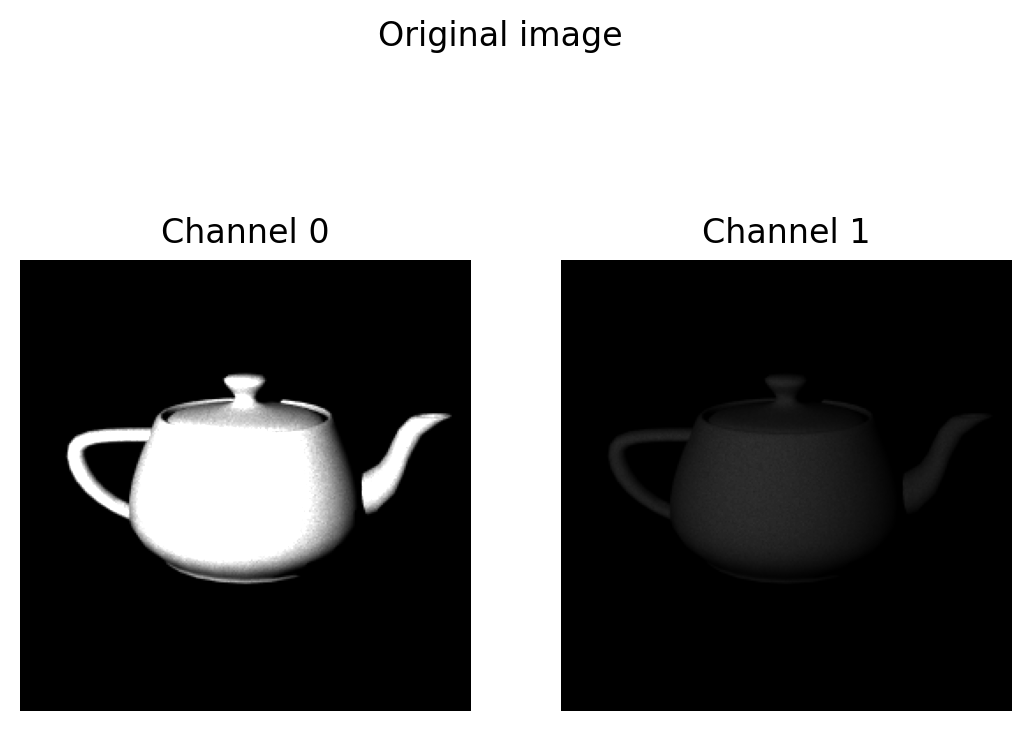

In [50]:
scene = mi.load_file("../scenes/simple_spectral.xml")

original_image = mi.render(scene, spp=512)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2)
fig.suptitle('Original image')
ax[0].axis('off')
ax[0].imshow(original_image[:,:,0], cmap='gray', vmin=0, vmax=100)
ax[0].set_title('Channel 0')
ax[1].axis('off')
ax[1].imshow(original_image[:,:,1], cmap='gray', vmin=0, vmax=100)
ax[1].set_title('Channel 1')

## Accessing scene parameters

Any Mitsuba object can be inspected using the [<code>traverse()</code>][1] function, which returns a instance of [<code>SceneParameters</code>][2]. It has a similar API to Python `dict` and holds all parameters that are exposed by the input object and its children. Therefore, when given a scene as input, this function will return the parameters of all the objects present in the scene.

Let's print the paramters available in our teapot scene.

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.traverse
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.SceneParameters

In [51]:
params = mi.traverse(scene)
print(params)

2023-08-25 10:55:49 DEBUG main [Scene] Scene GPU acceleration release ..

2023-08-25 10:55:49 DEBUG main [Scene] Free OptiX IAS..

SceneParameters[
  ------------------------------------------------------------------------------------------
  Name                                   Flags    Type           Parent
  ------------------------------------------------------------------------------------------
  sensor.near_clip                                float          PerspectiveCamera
  sensor.far_clip                                 float          PerspectiveCamera
  sensor.shutter_open                             float          PerspectiveCamera
  sensor.shutter_open_time                        float          PerspectiveCamera
  sensor.film.size                                ScalarVector2u SpecFilm
  sensor.film.crop_size                           ScalarVector2u SpecFilm
  sensor.film.crop_offset                         ScalarPoint2u  SpecFilm
  sensor.film.band1.range                         ScalarVector2f RegularSpectrum
  sensor.film.band1.values                        Float          RegularSpectrum
  sensor.

As you can see, the first level of our scene graph has 4 objects: 

- the camera (`sensor`)
- the teapot mesh (`teapot`)
- two light sources (`light1` and `light2`). 

Some of those objects have nested child objects, like `teapot.bsdf`.

Names like *teapot* are defined in the `id` field in the XML file. Parameters such as `teapot.vertex_positions` or `sensor.far_clip` are documented in their respective parent's plugin documentation (see [PLYMesh][1] and [PerspectiveCamera][2]). The plugin documentation lists which parameters are exposed, as well as all input parameters it takes in the XML file.

If you wish to modifiy a plugin's parameter that is not exposed with `traverse`, you still have the option to modify the XML file directly. `traverse` is merely a convenience function to edit scene objects in-place.

Individual scene parameters can be accessed with the `__getitem__` operator, providing the `key` corresponding to the parameter. Let's print some scene parameter values.

[1]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_shapes.html#ply-stanford-triangle-format-mesh-loader-ply
[2]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_sensors.html#perspective-pinhole-camera-perspective

In [8]:
print('sensor.near_clip:                    ',  params['sensor.near_clip'])
# light 1 spectrum was defined as a d65 spectrum, multiplied by scale factor 100
print('light1.intensity.range:              ',  params['light1.intensity.range'])
print('light1.intensity.values:             ',  params['light1.intensity.values'])
# light 2 spectrum was defined as an irregular spectrum
print('light2.intensity.wavelengths:        ',  params['light2.intensity.wavelengths'])
print('light2.intensity.values:             ',  params['light2.intensity.values'])
print('teapot.bsdf.reflectance.wavelengths: ',  params['teapot.bsdf.reflectance.wavelengths'])
print('teapot.bsdf.reflectance.values:      ',  params['teapot.bsdf.reflectance.values'])

sensor.near_clip:                     0.009999999776482582
light1.intensity.range:               [360.0, 830.0]
light1.intensity.values:              [117.77655792236328, 124.6590576171875, 131.54156494140625, 128.872802734375, 126.20404815673828, .. 85 skipped .., 131.2130126953125, 138.1343994140625, 145.05580139160156, 148.68191528320312, 152.3082733154297]
light2.intensity.wavelengths:         [444.0, 555.0, 666.0, 777.0]
light2.intensity.values:              [0.4440000057220459, 0.5550000071525574, 0.6660000085830688, 0.7770000100135803]
teapot.bsdf.reflectance.wavelengths:  [400.0, 500.0, 700.0, 800.0]
teapot.bsdf.reflectance.values:       [0.8999999761581421, 0.8999999761581421, 0.4000000059604645, 0.20000000298023224]


## Edit the scene

Similarly to a Python `dict`, parameters can be modified in-place using the `__setitem__` operator. However, it is necessary to call the `SceneParameters.update` method to properly apply the desired changes.

Some objects need to be notified if the children have been updated. For instance, a change to the vertex position buffer of a mesh will trigger the recomputation of the Embree/Optix BHV.

Internally, the `SceneParameters` object will record every update written to it.
Using `SceneParameters.update` will propagate all updates through the dependency graph, and perform all necessary updates to the parent objects.

In [9]:
# change the teapot's reflectance spectrum:
params['teapot.bsdf.reflectance.wavelengths'] = np.linspace(400, 700, 6)
params['teapot.bsdf.reflectance.values']      = [0., 0.1, 0.14, 0.9, .2, 0.]

# Apply updates
params.update();

After rendering the scene again, we can easily compare the rendered images using `matplotlib`. 

2023-08-25 10:54:20 INFO main [SamplingIntegrator] Starting render job (256x256, 512 samples)

2023-08-25 10:54:20 INFO main [SamplingIntegrator] Computation graph recorded. (took 5ms)

Text(0.5, 1.0, 'Channel 1')

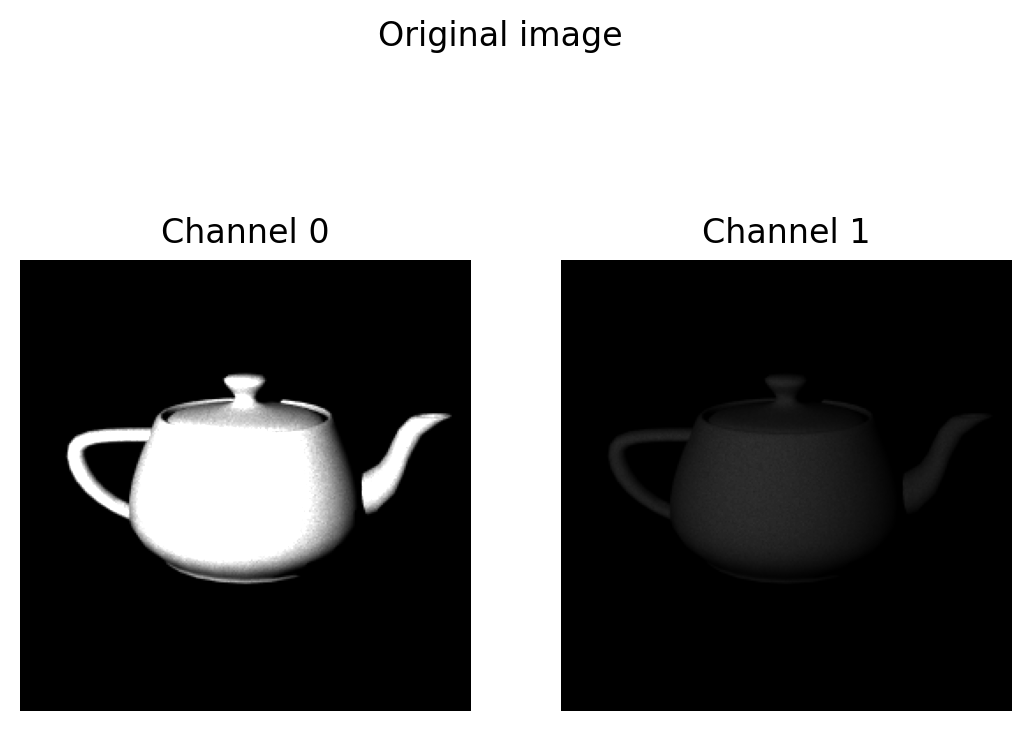

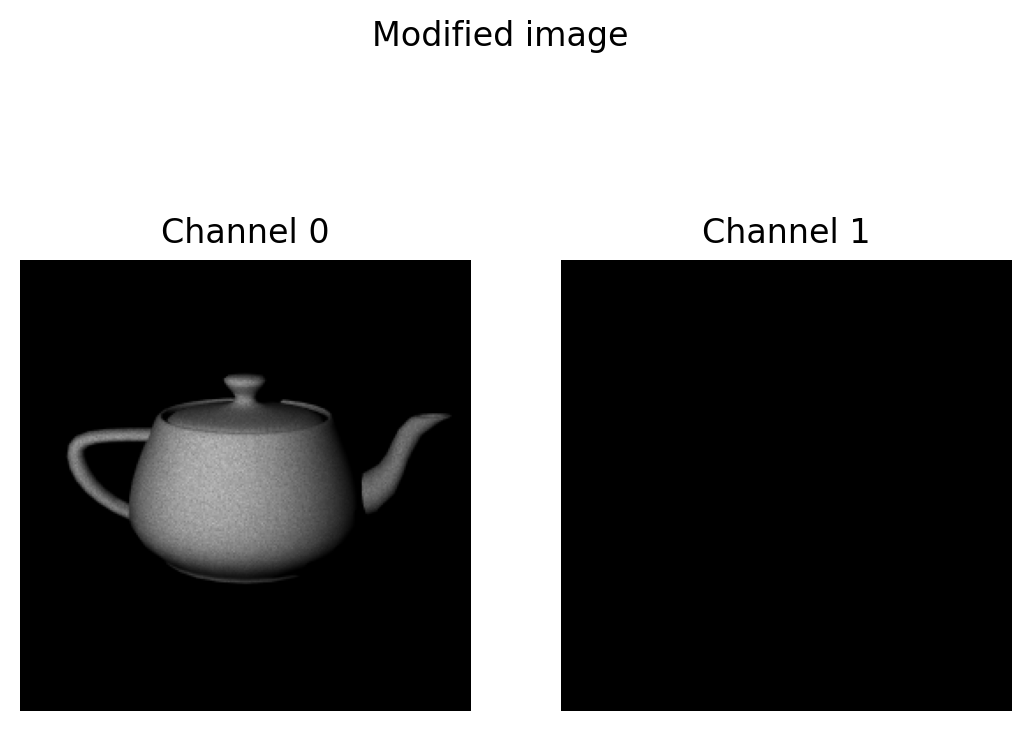

In [49]:
modified_image = mi.render(scene, spp=512)

fig, ax = plt.subplots(1,2)
fig.suptitle('Original image')
ax[0].axis('off')
ax[0].imshow(original_image[:,:,0], cmap='gray', vmin=0, vmax=100)
ax[0].set_title('Channel 0')
ax[1].axis('off')
ax[1].imshow(original_image[:,:,1], cmap='gray', vmin=0, vmax=100)
ax[1].set_title('Channel 1')

fig, ax = plt.subplots(1,2)
fig.suptitle('Modified image')
ax[0].axis('off')
ax[0].imshow(modified_image[:,:,0], cmap='gray', vmin=0, vmax=100)
ax[0].set_title('Channel 0')
ax[1].axis('off')
ax[1].imshow(modified_image[:,:,1], cmap='gray', vmin=0, vmax=100)
ax[1].set_title('Channel 1')


## See also

- [<code>mitsuba.traverse()</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.traverse)
- [<code>mitsuba.SceneParameters</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html##mitsuba.SceneParameters)